# Week 2: Principal Component Analysis


In this workshop, we will work through a set of problems on dimensionality reduction -- a cannonical form of unsupervised learning. Within the machine learning pipeline, dimensionality reduction is an important tool, which can used in EDA to understand patterns in the data, feature engineering to create a low-dimensional representation of the inputs, and in the final phase when you are presenting and visualizing your solution.

As usual, the worksheets will be completed in teams of 2-3, using **pair programming**, and we have provided cues to switch roles between driver and navigator. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 
>- Look for the 🏁 as cue to switch roles between driver and navigator.
>- In some Exercises, you will see some beneficial hints at the bottom of questions.

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given. 

As you work through the problems it will help to refer to your lecture notes (navigator). The exercises here are designed to reinforce the topics covered this week. Please discuss with the tutors if you get stuck, even early on! 


## Outline

1. [Problem Definition and Setup](#setup)

2. [Principal Component Analysis](#pca)

  a. [Examining the Basis Vectors and Scores](#basis)

  b. [Selecting the Number of Components](#nocomponents)

  c. [Other Digits](#other)

# Problem Definition and Setup <a id='setup'></a>

## Packages

First, lets load in some packages to get us started. 

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#myImports
from random import randrange

## Data

Our dataset will be the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits, which we will download from sklearn. The dataset consists of a set of greyscale images of the numbers 0-9 and corresponding labels. Usually the goal is to train a classifier (i.e. given an image, what digit does it correspond to?). Here we will throw away the labels and focus on the images themselves. Specifically, we will use dimensionality reduction to explore the images and underlying patterns and find a low-dimensional representation.

First, load the data:

In [94]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',parser = 'auto')
X = mnist.data
y = mnist.target

### 🚩 Exercise 1 (CORE)

What object is returned by the command above? What shape/datatype etc if an array?  

In [95]:
print(type(mnist))
print(y)

<class 'sklearn.utils._bunch.Bunch'>
0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']


An array of [70000 rows x 784 columns], which is 70000 images of 28px by 28px

Now, let's create a dictionary, with the digit classes (0-9) as keys, where the correponding values are the set of all images corresponding to that particular label. 

In [96]:
digits_dict = {}
X_= X.values
count = 0

for label in y:
  if label in digits_dict:
    digits_dict[label] += [X_[count]]
  else:
    digits_dict[label] = [X_[count]]
  count += 1

### 🚩 Exercise 2 (CORE)

Picking some of labels and plot a few images from within the dictionary. Note that each image contains a total of 784 pixels (28 by 28) and you will need to `reshape` the image to plot with `imshow(...,cmap='gray_r')`.

here is a 4


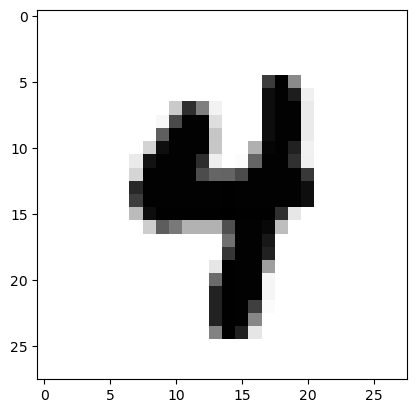

In [97]:
#Pick a random digit(0-9)
character = str(randrange(10))
print("here is a " + character)

#Pick a random image of the chosen digit
randChar = digits_dict[character][randrange(len(digits_dict[character]))]

#Create a function for displaying digits
def plotNumber(char):
    number = char.reshape((28, 28))
    plt.imshow(number, cmap ='gray_r')

#Plot the digit
plotNumber(randChar)



### 🚩 Exercise 3 (CORE)

Now focus on the 3s only and create a data matrix called `X_threes` of dimension $N$ (# datapoints) by $D$ (# features).

What are the features in this problem? How many features and data points are there? 

In [98]:
X_threes = digits_dict['3']
print("There are: " + str(len(X_threes)) + " datapoints")
print("With: " + str(len(X_threes[1])) + " features each")

X_threes = np.array(X_threes)

There are: 7141 datapoints
With: 784 features each


Here features are individual pixels of the image

### 🚩 Exercise 4 (CORE)

Now compute and plot the mean image of three.

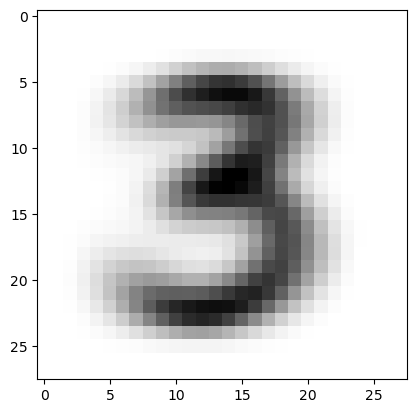

In [99]:
X_three_mean = X_threes.mean(axis=0)
plotNumber(X_three_mean)

Run the following code to first create a new data matrix that centers the data by subtracting the mean image, and then visualise some of the images and compare to the original data. Note: you will need to replace `X_three_mean` with the name you gave the mean image in the computation above.

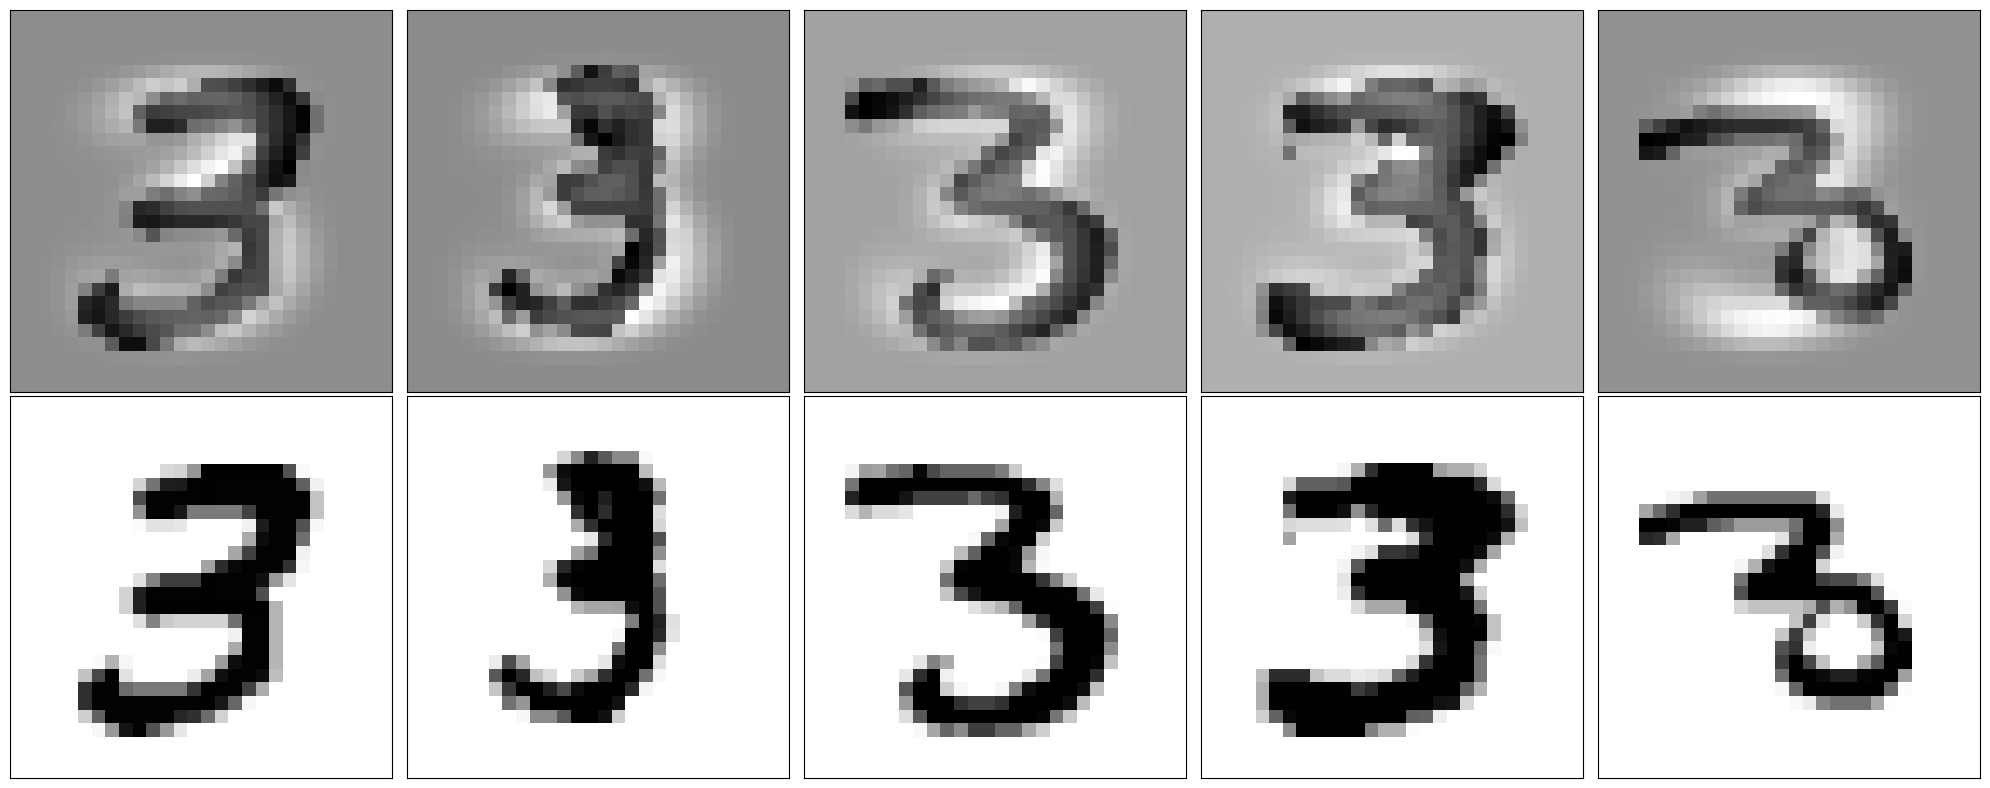

In [100]:
X_three_centred = X_threes - X_three_mean

n_images = 5

fig = plt.figure(figsize=(4*n_images, 4*2))
for j in range(n_images):
  ax = fig.add_subplot(2, n_images, j+1)
  ax.imshow(X_three_centred[j,:].reshape((28,28)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, n_images, j+1+n_images)
  ax.imshow(X_threes[j,:].reshape((28,28)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])
fig.tight_layout()

### 🚩 Exercise 5 (CORE)

Comment on whether or not the images need to be standardized before using PCA

No, becuase we will have a lot of pixels in the corned that will have a low variabilaty

🏁 **Now, is a good point to switch driver and navigator**

# PCA <a id='pca'></a>

Now, we will perform PCA to summarize the main patterns in the images. We will use the [`PCA()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) transform from the `sklearn.decomposition` package:

- We can specify the number of components with the option `n_components`. If omitted, all components are kept.

- Note that by default the `PCA()` transform centers the variables to have zero mean (but does not scale them). After fitting, we can access the mean through the attribute `mean_`

- We can access the basis vectors (principal components) through the `components_` attribute.

- We can call `fit()` to fit the model, followed by `transform` to obtain the low-dimensional representation (or also `fit_transform`). 

 First, let's create the PCA transform and call `fit()`:

In [101]:
pca_threes = PCA(n_components = 200)
pca_threes.fit(X_threes)


PCA(n_components=200)

## Examining the Basis Vectors and Scores <a id='basis'></a>

### 🚩 Exercise 6 (CORE)
 
Plot the mean image by accessing the `mean_` attribute and check that it is the same as above.

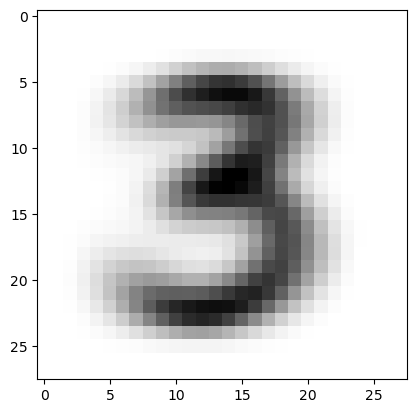

In [102]:
plotNumber(pca_threes.mean_)

### 🚩 Exercise 7 (CORE)

Plot the the first ten basis vectors as images by accessing the `components_` attribute. What patterns do they describe? From an exploratory perspective, do they all describe interesting patterns?

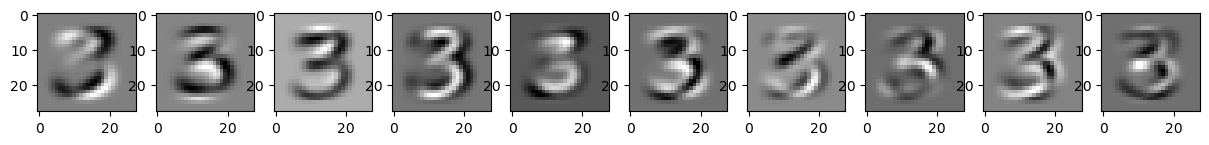

In [103]:
fig, axs = plt.subplots(1,10, figsize = (15, 6), facecolor = 'w', edgecolor = 'k')
for i in range(10):
    axs[i].imshow(pca_threes.components_[i].reshape(28,28,1), cmap = 'gray_r')

Rotation, centred and how condensed as described with faces during the lecture

### 🚩 Exercise 8 (CORE)

a) Use the `transform()` method to compute the scores and save them in an object called `scores`. Then, plot the data points in the low-dimensional space spanned by the first two principal components. 

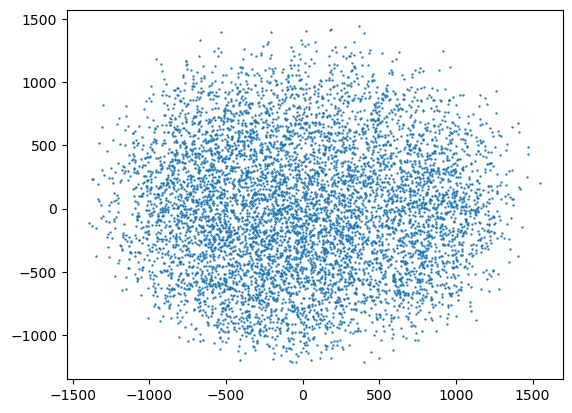

In [104]:
scores = pca_threes.transform(X_threes)

N = 7141
plt.scatter(scores[:, 0], scores[:, 1], s=0.45)

To better interpret the latent dimensions, let's look at some projected points along each dimension and the corresponding images. Specifically, run the following code to:

- first compute the $5, 25, 50, 75, 95\%$ quantiles of the scores for the first two dimensions
- then find the data point whose projection is closest to each combination of quantiles.

In [105]:
s1q = np.quantile(scores[:,0],[.05,.25,.5,.75,.95])
s2q = np.quantile(scores[:,1],[.05,.25,.5,.75,.95])

idx = np.zeros([len(s1q),len(s2q)])

for i in range(len(s1q)):
    for j in range(len(s2q)):
        aux = ((scores[:,0] - s1q[i])**2 + (scores[:,1] - s2q[j])**2).reshape(7141,1)
        idx[i,j] = np.where(aux == min(aux))[0][0]

b) Now, add these points in red to your plot above in.

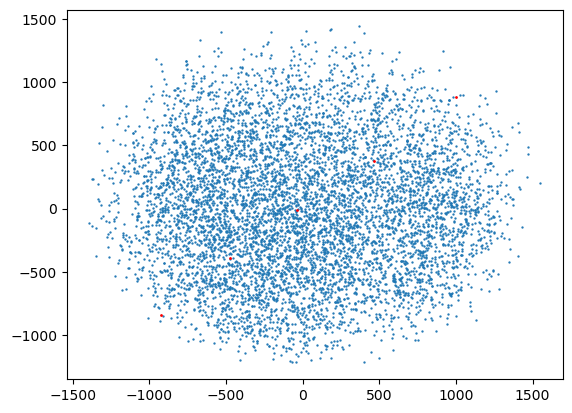

In [106]:
plt.scatter(scores[:, 0], scores[:, 1], s=0.45)
plt.scatter(s1q, s2q, s=1, color = 'r')

c) Run the following code to plot the images corresponding to this grid of points. Describe the patterns of the first and second principal components.

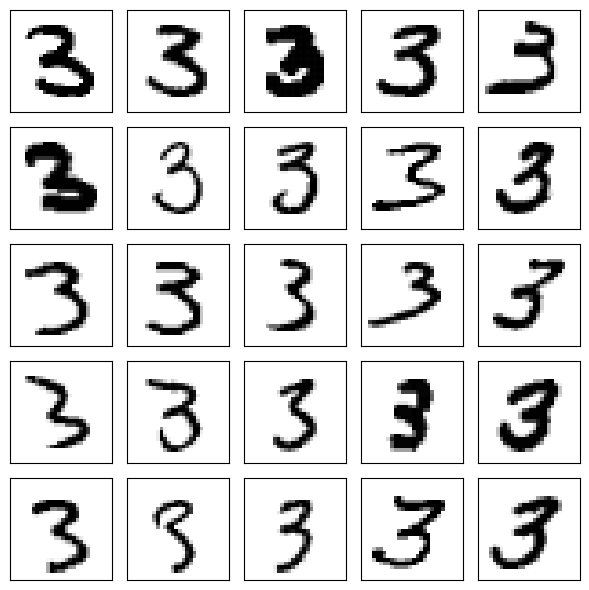

In [107]:
fig, ax = plt.subplots(len(s1q),len(s2q),figsize=(6,6))
for i in range(len(s1q)):
    for j in range(len(s2q)):
        ax[len(s2q)-1-j,i].imshow(X_threes[int(idx[i,j]),:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

We can see that the first components corresponds to the shape of the digit.
We can see that the second of the components corresponds to the tilt. (angle of the digit to vertical axis)


You can also try to create some artificial images, by fixing different values of the weights. This can also help to interpret the latent dimensions. 

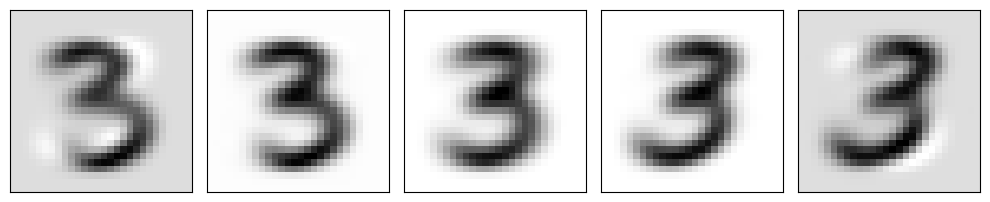

In [108]:
weight1 = [-1000,-500,0,500,1000]
weight2 = 0

images_pc1 = np.zeros([len(weight1),784])

count = 0



for w in weight1:   
    images_pc1[count,:] =(pca_threes.mean_ + pca_threes.components_[0,:]*w+pca_threes.components_[1,:]*weight2)
    count += 1
    

fig, ax = plt.subplots(1,len(weight1),figsize=(10,6))
for i in range(len(weight1)):
    ax[i].imshow(images_pc1[i,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

### 🚩 Exercise 9 (CORE)

Repeat this to describe the third principal component. What values of weights should you use? 

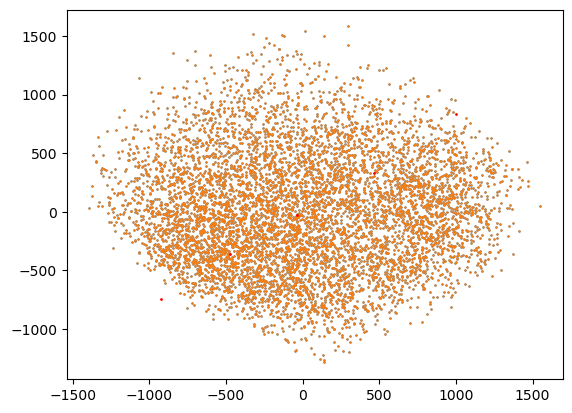

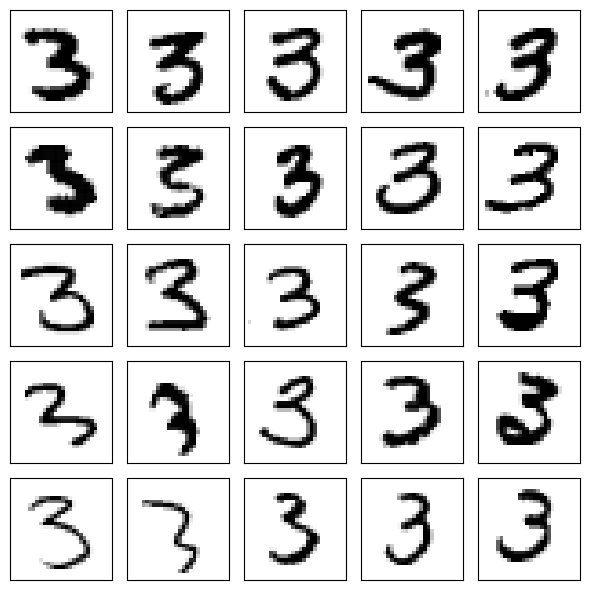

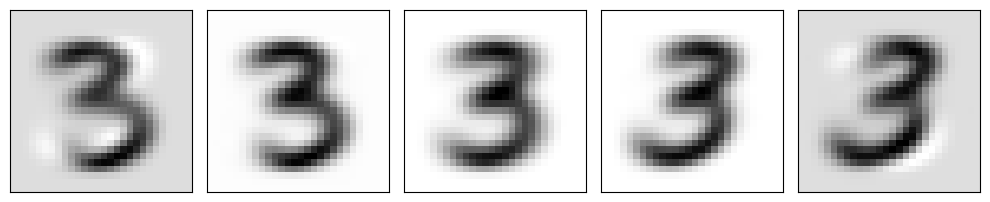

In [109]:
scores = pca_threes.transform(X_threes)

N = 7141
plt.scatter(scores[:, 0], scores[:, 2], s=0.45)

s1q = np.quantile(scores[:,0],[.05,.25,.5,.75,.95])
s2q = np.quantile(scores[:,2],[.05,.25,.5,.75,.95])

idx = np.zeros([len(s1q),len(s2q)])

for i in range(len(s1q)):
    for j in range(len(s2q)):
        aux = ((scores[:,0] - s1q[i])**2 + (scores[:,2] - s2q[j])**2).reshape(7141,1)
        idx[i,j] = np.where(aux == min(aux))[0][0]
        
        
plt.scatter(scores[:, 0], scores[:, 2], s=0.45)
plt.scatter(s1q, s2q, s=1, color = 'r')

fig, ax = plt.subplots(len(s1q),len(s2q),figsize=(6,6))
for i in range(len(s1q)):
    for j in range(len(s2q)):
        ax[len(s2q)-1-j,i].imshow(X_threes[int(idx[i,j]),:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

weight1 = [-1000,-500,0,500,1000]
weight2 = 0

images_pc1 = np.zeros([len(weight1),784])

count = 0



for w in weight1:   
    images_pc1[count,:] =(pca_threes.mean_ + pca_threes.components_[0,:]*w+pca_threes.components_[1,:]*weight2)
    count += 1
    

fig, ax = plt.subplots(1,len(weight1),figsize=(10,6))
for i in range(len(weight1)):
    ax[i].imshow(images_pc1[i,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

The third component also describes shape, just like the second, but in a slightly different manner. We can use the same weights for this part. 

### 🚩 Exercise 10 (EXTRA)

In lecture, we saw that we can also compute the basis vectors from an SVD decomposition of the data matrix. Use the `svd` function in `scipy.linalg` to compute the first three basis vectors and verify that they are the same (up to a change in sign -- note that the signs may be flipped because each principal component specifies a direction in the $D$-dimensional space and flipping the sign has no effect as the direction does not change). 

Does `PCA()` perform principal component analysis using an eigendecomposition of the empirical covariance matrix or using a SVD decomposition of the data matrix?

🏁 **Now, is a good point to switch driver and navigator**

## Selecting the Number of Components <a id='nocomponents'></a>

### 🚩 Exercise 11 (CORE)

Next, let's investigate how many components are needed by considering how much varaince is explained by each component.

Note that the `pca_threes` object has an attribute `explained_variance_` (variance of each component) and `explained_variance_ratio_` (proportion of variance explained by each component). 

Plot both the proportion of variance explained and the cummulative proportion of variance explained. Provide a suggestion of how many components to use. How much variance is explained by the suggest number of components? Comment on why we may be able to use this number of components in relation to the total number of features.

<br>
<details><summary><b><u>Hint</b></u></summary>

You can use `cumsum()` to compute the cummulative sum of the elements in a vector.
</details>

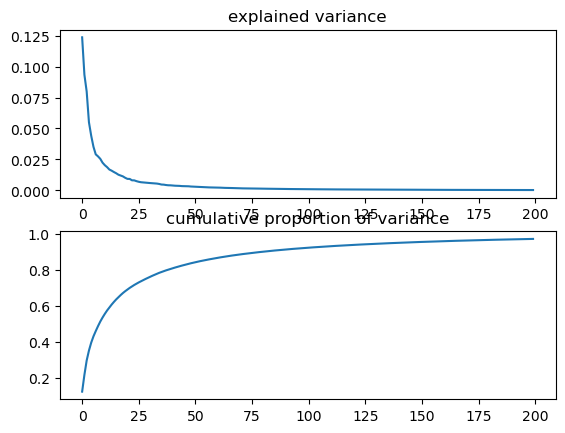

In [110]:
variance_df = pca_threes.explained_variance_ratio_.cumsum()

figure, axis = plt.subplots(2)
axis[0].plot(pca_threes.explained_variance_ratio_)
axis[0].set_title("explained variance") 
axis[1].plot(variance_df)
axis[1].set_title("cumulative proportion of variance") 

plt.show()

# count = 1
# for i in variance_df:
#     print(count, " ", i)
#     count +=1 



We can see that 80 components explain 90% of variance, so reducing data from 784 dimension to only 80 will preserve 90% of change. To explain 95% of variance, we'd need to use 138 features, which still is a huge decrease compared to the original 784.

### 🚩 Exercise 12 (CORE)

For your selected number of components, compute the reconstruted images. Plot the reconstruction for a few images and compare with the original images. Comment on the results.  

<br>
<details><summary><b><u>Hint</b></u></summary>

You can use `inverse_transform()` to decode the scores.
</details>

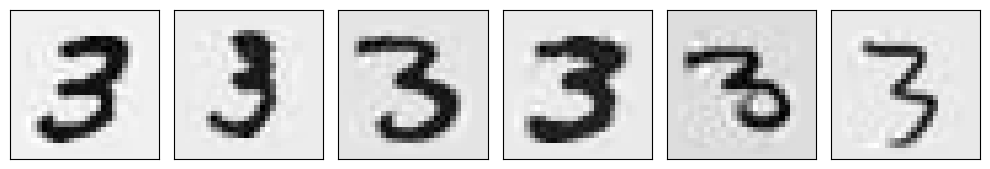

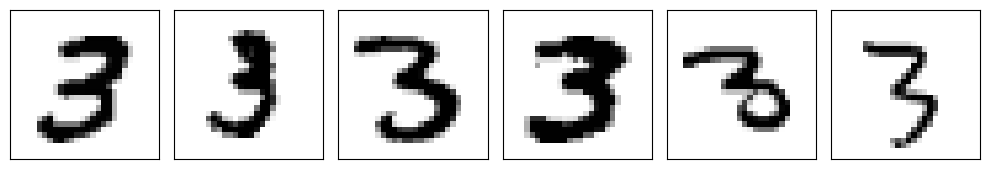

In [111]:
#plotNumber(PCA.inverse_transform(scores))

unpca_threes = pca_threes.inverse_transform(scores)
#print(unpca_three.shape)

fig, ax = plt.subplots(1, 6,figsize=(10,6))
for i in range(6):
    ax[i].imshow(unpca_threes[i,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()


fig, ax = plt.subplots(1, 6,figsize=(10,6))
for i in range(6):
    ax[i].imshow(X_threes[i,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()



We can see that overall shape remains very precise with 200 compnens. It's really noticeable, that there is some halo around every digit. Some prepocessing of unused dimensions might help to reduce this effect. (?)

🏁 **Now, is a good point to switch driver and navigator**

## Other Digits <a id='other'></a>

Now, let's consider another digit. 

### 🚩 Exercise 13 (CORE)

Perform PCA for another choice of digits. What do the first two components describe? Do some digits have better approximations than others? Comment on why this may be.

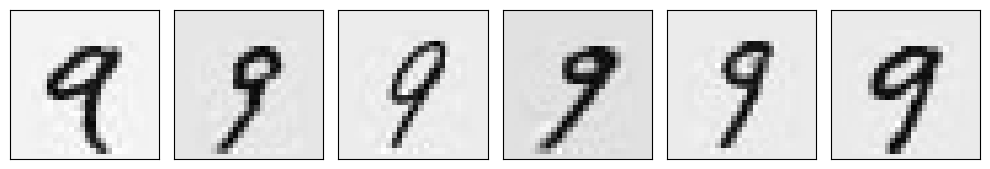

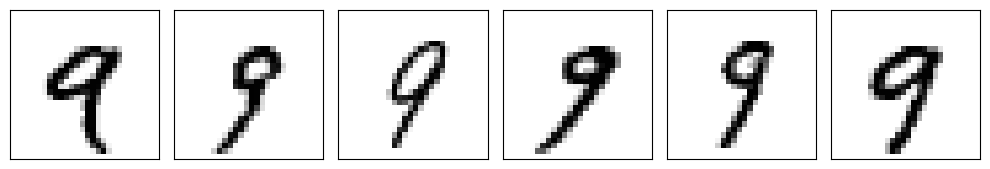

In [112]:
X_digit = digits_dict['9']
pca_digit = PCA(n_components = 200)
scores = pca_digit.fit_transform(X_digit)
unpca_digit = pca_digit.inverse_transform(scores)
X_digit = np.array(X_digit)



fig, ax = plt.subplots(1, 6,figsize=(10,6))
for i in range(6):
    ax[i].imshow(unpca_digit[i,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()


fig, ax = plt.subplots(1, 6,figsize=(10,6))
for i in range(6):
    ax[i].imshow(X_digit[i,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

### Exercise 14 (EXTRA)

Finally, consider now all of your images (for all digits). Compute and plot some of the principle components for this dataset.

Plot the projection of the data in the latent space and color the data by the labels. What do you observe?


# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please go to Edit -> Edit Notebook Metadata and change 'Student 1' and 'Student 2' in the **name** attribute to include your name.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF.

In [113]:
!jupyter nbconvert --to pdf mlp_week02.ipynb 

[NbConvertApp] Converting notebook mlp_week02.ipynb to pdf
[NbConvertApp] Writing 492861 bytes to mlp_week02.pdf
